In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [3]:
tf.random.set_seed(1234)

In [6]:
df=pd.read_csv('/home/sh4n1/miniproj/h1cpudata.csv',usecols=[1],engine='python')

In [7]:
df

,cpu_usage
0,10912.027692
1,10890.570362
2,10434.114431
3,10539.450415
4,10951.041020
...,...
8629,83.878654
8630,81.927988
8631,76.075989
8632,85.829320


In [9]:
# Split train data and test data
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [10]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [12]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (6877, 30, 1)
y_train.shape:  (6877, 1)
X_test.shape:  (1697, 30, 1)
y_test.shape:  (1697, 1)


In [14]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

2021-11-13 03:41:19.675177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 03:41:19.686228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-13 03:41:19.686269: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-13 03:41:19.686741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [15]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

2021-11-13 03:41:48.665656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
344/344 [==============================] - 11s 24ms/step - loss: 0.0121 - val_loss: 0.0138
Epoch 2/100
344/344 [==============================] - 8s 22ms/step - loss: 0.0040 - val_loss: 0.0113
Epoch 3/100
344/344 [==============================] - 8s 23ms/step - loss: 0.0029 - val_loss: 0.0090
Epoch 4/100
344/344 [==============================] - 7s 21ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 5/100
344/344 [==============================] - 7s 20ms/step - loss: 0.0042 - val_loss: 0.0148
Epoch 6/100
344/344 [==============================] - 8s 22ms/step - loss: 0.0085 - val_loss: 0.0147
Epoch 7/100
344/344 [==============================] - 8s 22ms/step - loss: 0.0079 - val_loss: 0.0093
Epoch 8/100
344/344 [==============================] - 7s 21ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 9/100
344/344 [==============================] - 8s 22ms/step - loss: 0.0037 - val_loss: 0.0066
Epoch 10/100
344/344 [==============================] - 7s 21ms/step - loss: 0.00

In [16]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

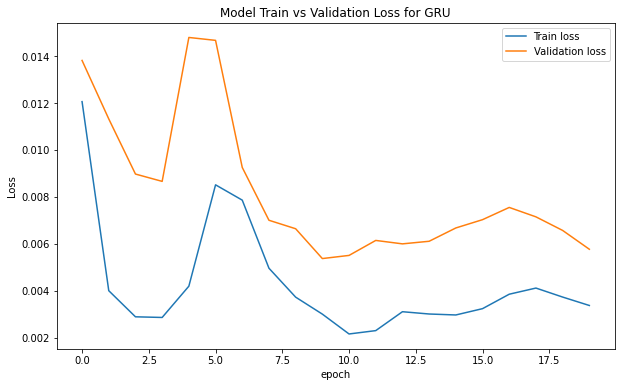

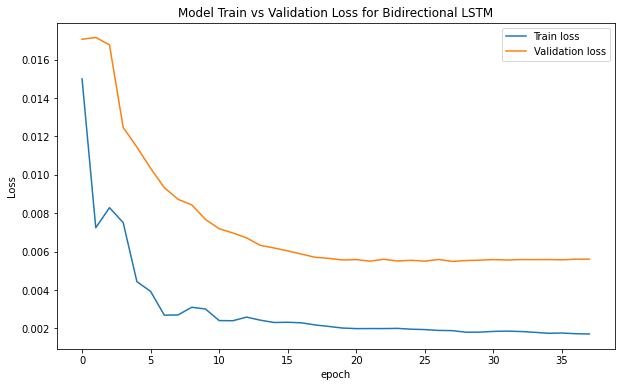

In [19]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

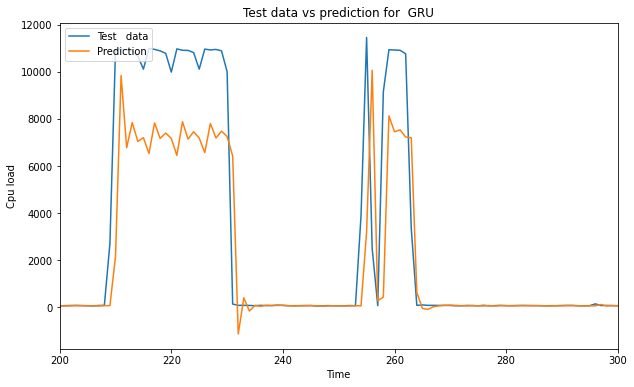

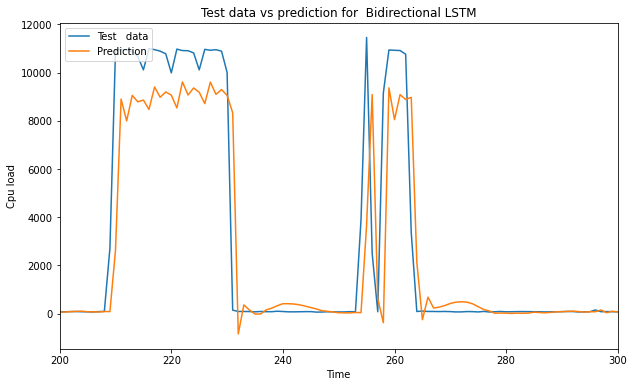

In [25]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for  '+ model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Cpu load')
    plt.xlim(200,300)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)


In [26]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')

GRU:
Mean Absolute Error: 359.3560
Root Mean Square Error: 1217.7169

Bidirectional LSTM:
Mean Absolute Error: 256.4979
Root Mean Square Error: 961.9970

